In [1]:
import os
import SimpleITK as sitk
import six
import matplotlib.pyplot as plt
import pydicom
import pydicom.data
import PyQt5
import numpy as np
import os, glob
import pydicom
import pylab as pl
import sys
import sys
sys.path.append('../../src/jupyter/')
import matplotlib.path as mplPath
import keyboard
import nibabel as nib
from radiomics import featureextractor 
from radiomics import imageoperations
from collections import OrderedDict
from IPython.core.display import display, HTML
from util import pyvis
import nrrd

%matplotlib widget
display(HTML("<style>.container { width:100% !important; }</style>"))

Skipping torch import
Skipping torch import


In [2]:
# Load QSM and segmentation
seg = nib.load('F:/dbs/mclaro/chh/roi/01_roi_combined.nii')
qsm = nib.load('F:/dbs/mclaro/chh/gt/00001_qsm.nii.gz')
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
# Partition mask
seg_mask = seg.get_fdata()
lstn_mask = seg_mask == 2
rstn_mask = seg_mask == 3

In [74]:
# Convert to SITK images
roi_masks = [lstn_mask,rstn_mask]
# qsm_np = np.rot90(np.swapaxes(np.dstack(qsm.get_fdata()),0,2))
# qsm_sitk = sitk.GetImageFromArray(qsm_np) 
qsm_sitk = sitk.GetImageFromArray(qsm.get_fdata())
for i in range(len(roi_masks)):
    seg_sitk = sitk.GetImageFromArray(np.float64(roi_masks[i]))
# Extract 1st order features
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
print('Enabled features:\n\t', extractor.enabledFeatures)
features = OrderedDict()
featureVector = extractor.execute(qsm_sitk,seg_sitk,voxelBased=True)
result = features
Finalresult=six.iteritems(result)
p = 7
for key, value in six.iteritems(featureVector):
    if isinstance(value, sitk.Image):
        sitk.WriteImage(value, key + '.nrrd',True)
        sitk.WriteImage(seg_sitk, 'seg' + '.nrrd',True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))        
    else:  # Diagnostic information
        print("\t%s: %s" %(key, value))
        if key == 'diagnostics_Mask-original_BoundingBox':
            lims = value
            bb = ((lims[0]-1,lims[0]+lims[3]+1),(lims[1]-1,lims[1]+lims[4]+1),(lims[2]-1,lims[2]+lims[5]+1))
            print('Bounding box:',bb)
            bbi = ((lims[0]-2,lims[0]+lims[3]),(lims[1]-2,lims[1]+lims[4]),(lims[2]-2,lims[2]+lims[5]))
            bbp = ((lims[0]-p,lims[0]+lims[3]+1+p),(lims[1]-1-p,lims[1]+lims[4]+1+p),(lims[2]-1-p,lims[2]+lims[5]+1+p))
            bbpi = ((lims[0]-p-1,lims[0]+lims[3]+1+p-1),(lims[1]-1-p-1,lims[1]+lims[4]+1+p-1),(lims[2]-1-p-1,lims[2]+lims[5]+1+p-1))
            print('Bounding box interior:',bbi)
            # Assuming kernel radius of 3, slide of 1, and padding of 0
            sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop' + '.nrrd',True)
            sitk.WriteImage(seg_sitk[lims[0]-p:lims[0]+lims[3]+1+p,lims[1]-1-p:lims[1]+lims[4]+1+p,lims[2]-1-p:lims[2]+lims[5]+1+p], 'seg_precrop' + '.nrrd',True)
            sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop' + '.nrrd',True)
            sitk.WriteImage(qsm_sitk[lims[0]-p:lims[0]+lims[3]+1+p,lims[1]-1-p:lims[1]+lims[4]+1+p,lims[2]-1-p:lims[2]+lims[5]+1+p], 'qsm_precrop' + '.nrrd',True)

Enabled features:
	 {'firstorder': []}
	diagnostics_Versions_PyRadiomics: v3.0.1
	diagnostics_Versions_Numpy: 1.21.5
	diagnostics_Versions_SimpleITK: 2.2.1
	diagnostics_Versions_PyWavelet: 1.3.0
	diagnostics_Versions_Python: 3.7.15
	diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'voxelBased': True}
	diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
	diagnostics_Image-original_Hash: 1fd31d96d746e79c07ea3234fd69d4993d1d4219
	diagnostics_Image-original_Dimensionality: 3D
	diagnostics_Image-original_Spacing: (1.0, 1.0, 1.0)
	diagnostics_Image-original_Size: (160, 256, 256)
	diagnostics_Image-original_Mean: -28427.60092716217
	diagnostics_Image-original_Minimum:

In [75]:
bb_mask = np.zeros_like(sitk.GetArrayFromImage(qsm_sitk))
bbi_mask = np.zeros_like(sitk.GetArrayFromImage(qsm_sitk))
bbp_mask = np.zeros_like(sitk.GetArrayFromImage(qsm_sitk))
bbpi_mask = np.zeros_like(sitk.GetArrayFromImage(qsm_sitk))

In [78]:
bb_mask[bb[2][0]:bb[2][1],bb[1][0]:bb[1][1],bb[0][0]:bb[0][1]] = 1
bbi_mask[bbi[2][0]:bbi[2][1],bbi[1][0]:bbi[1][1],bbi[0][0]:bbi[0][1]] = 1
#(-bbi[2][0]+bbi[2][1],-bbi[1][0]+bbi[1][1],-bbi[0][0]+bbi[0][1])
bb_mask = abs(bb_mask-bbi_mask)*1000
bbp_mask[bbp[2][0]:bbp[2][1],bbp[1][0]:bbp[1][1],bbp[0][0]:bbp[0][1]] = 1
bbpi_mask[bbpi[2][0]:bbpi[2][1],bbpi[1][0]:bbpi[1][1],bbpi[0][0]:bbpi[0][1]] = 1
bbp_mask = abs(bbp_mask-bbpi_mask)*1000

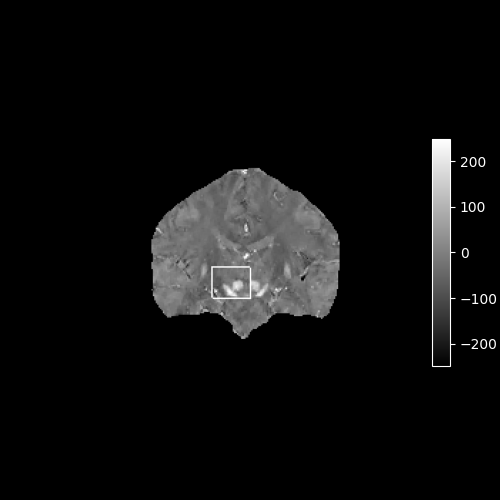

In [88]:
pyvis(np.flip(np.rot90(np.swapaxes((qsm.get_fdata()+1000*(bbp_mask)+1000*rstn_mask),0,2))),5,5,'gray',500,0,-250,250)

In [89]:
qsm_crop_sitk = qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1]
qsmp_data = sitk.GetArrayFromImage(sitk.ReadImage('qsm_precrop.nrrd'))
segp_data = sitk.GetArrayFromImage(sitk.ReadImage('seg_precrop.nrrd'))
qsm_data = sitk.GetArrayFromImage(sitk.ReadImage('qsm_crop.nrrd'))
seg_data = sitk.GetArrayFromImage(sitk.ReadImage('seg_crop.nrrd'))
grad_sitk = sitk.Gradient(qsm_crop_sitk)
sitk.WriteImage(grad_sitk, 'grad' + '.nrrd',True)

grad_data, grad_header = nrrd.read('grad.nrrd')
mean, mean_header = nrrd.read('original_firstorder_Mean.nrrd')
median, median_header = nrrd.read('original_firstorder_Median.nrrd')
variance, variance_header = nrrd.read('original_firstorder_Variance.nrrd')
skewness, skewness_header = nrrd.read('original_firstorder_Skewness.nrrd')
kurtosis, kurtosis_header = nrrd.read('original_firstorder_Kurtosis.nrrd')
energy, energy_header = nrrd.read('original_firstorder_Energy.nrrd')
entropy = seg_data = sitk.GetArrayFromImage(sitk.ReadImage('original_firstorder_Entropy.nrrd'))


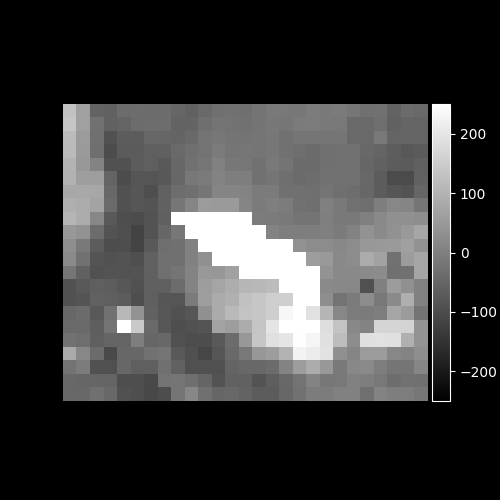

In [90]:
pyvis(np.flip(np.rot90(np.swapaxes((qsmp_data+1000*(segp_data)),0,2))),5,5,'gray',500,0,-250,250)

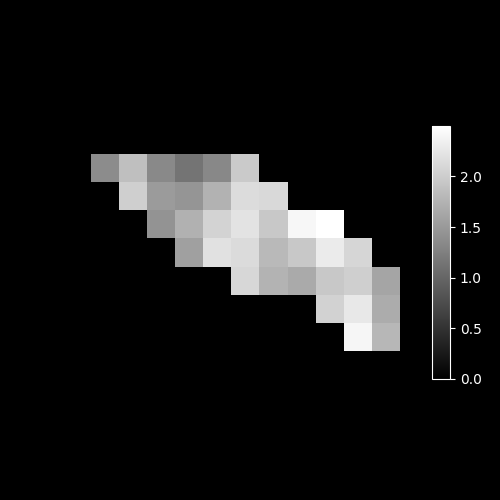

In [91]:
# Plot
pyvis(np.flip(np.rot90(np.swapaxes((entropy),0,2))),5,5,'gray',0,0,0,0)